## ЗАГАЛЬНА ПІДГОТОВКА. ІМПОРТ УСІХ НЕОБХІДНИХ БІБЛІОТЕК ТА ВКАЗАННЯ ПАРАМЕТРІВ НАВЧАННЯ

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#ВАШІ ПАРАМЕТРИ МОДЕЛІ ДЛЯ ЇЇ НАВЧАННЯ
batch_size = 32
learning_rate = 0.001
num_epochs = 10
train_percentage = 0.8  

#Базова трансформація зображень. ВАЖЛИВО: АУГМЕНТАЦІЯ ВЖЕ ПРОВЕДЕНА, ДАТАСЕТ ПОВНІСТЮ ГОТОВИЙ ДО РОБОТИ. РОБОЧИЙ РОЗМІР ЗОБРАЖЕНЬ: 256 X 256.
transform = transforms.Compose([
    transforms.Resize((256, 256)),           
    transforms.ToTensor()             
])

full_dataset = datasets.ImageFolder('/kaggle/input/firedataset/dataset_new/dataset', transform=transform)

#Розділення на тестову та тренувальну вибірки
def split_dataset_by_class(dataset, train_percentage):
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.imgs):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    train_indices = []
    test_indices = []

    for label, indices in class_indices.items():
        train_idx, test_idx = train_test_split(indices, train_size=train_percentage, random_state=42)
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, test_subset

#ПІДГОТОВКА DATALOADER-ів
train_dataset, test_dataset = split_dataset_by_class(full_dataset, train_percentage)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## ІНІЦІАЛІЗАЦІЯ МОДЕЛІ (БЕЗ ВИКОРИСТАННЯ ОТРИМАНИХ ВАГІВ)

In [2]:
#ІНІЦІАЛІЗАЦІЯ МОДЕЛІ
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 класса: clear, fire

#Оптимізатор та функція втрат
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#Перенесення на GPU (по можливості)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 274MB/s]  


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## ТРЕНУВАННЯ НЕЙРОМЕРЕЖІ. ЗБЕРЕЖЕННЯ СТАТИСТИКИ НАВЧАННЯ ДЛЯ ВІЗУАЛІЗАЦІЇ

In [3]:
def train_model(model, criterion, optimizer, num_epochs):
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        #навчання
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_epoch_loss = running_loss / len(train_dataset)
        train_epoch_acc = running_corrects.double() / len(train_dataset)

        train_loss_history.append(train_epoch_loss)
        train_accuracy_history.append(train_epoch_acc)

        # Валідація (обчислення Test- характеристик)
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        test_epoch_loss = running_loss / len(test_dataset)
        test_epoch_acc = running_corrects.double() / len(test_dataset)

        test_loss_history.append(test_epoch_loss)
        test_accuracy_history.append(test_epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_acc:.4f}, Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.4f}')

    return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

#Виклик циклу навчання
train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10, Train Loss: 0.2044, Train Accuracy: 0.9241, Test Loss: 0.1925, Test Accuracy: 0.9270
Epoch 2/10, Train Loss: 0.1126, Train Accuracy: 0.9657, Test Loss: 0.0512, Test Accuracy: 0.9818
Epoch 3/10, Train Loss: 0.0701, Train Accuracy: 0.9744, Test Loss: 0.0349, Test Accuracy: 0.9909
Epoch 4/10, Train Loss: 0.0633, Train Accuracy: 0.9771, Test Loss: 0.0377, Test Accuracy: 0.9818
Epoch 5/10, Train Loss: 0.0416, Train Accuracy: 0.9840, Test Loss: 0.0707, Test Accuracy: 0.9653
Epoch 6/10, Train Loss: 0.0377, Train Accuracy: 0.9858, Test Loss: 0.0563, Test Accuracy: 0.9781
Epoch 7/10, Train Loss: 0.0260, Train Accuracy: 0.9909, Test Loss: 0.0793, Test Accuracy: 0.9653
Epoch 8/10, Train Loss: 0.0269, Train Accuracy: 0.9895, Test Loss: 0.0818, Test Accuracy: 0.9726
Epoch 9/10, Train Loss: 0.0559, Train Accuracy: 0.9822, Test Loss: 0.0244, Test Accuracy: 0.9909
Epoch 10/10, Train Loss: 0.0183, Train Accuracy: 0.9950, Test Loss: 0.0133, Test Accuracy: 0.9927


In [9]:
#ЗБЕРЕЖЕННЯ МОДЕЛІ
model_save_path = 'model_final.pth'
torch.save(model.state_dict(), model_save_path)

## ЗАВАНТАЖЕННЯ ГОТОВИХ ВАГІВ МОДЕЛІ (БЕЗ ДОДАТКОВОГО НАВЧАННЯ). ЗНАЙДІТЬ ФАЙЛ ІЗ РОЗШИРЕННЯМ .pth ТА ДОДАЙТЕ ШЛЯХ ДО НЬОГО В НАСТУПНИЙ КОД:

In [5]:
#ВАШ ШЛЯХ ІЗ ФАЙЛОМ ВАГІВ

model_load_path = "/kaggle/working/model_final.pth"

#завантаження самих вагів. 
model.load_state_dict(torch.load(model_load_path))

#Перенесення на GPU (По можливості)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## ТЕСТУВАННЯ МОДЕЛІ НА ВИПАДКОВИХ ЗОБРАЖЕННЯХ З ДАТАСЕТУ

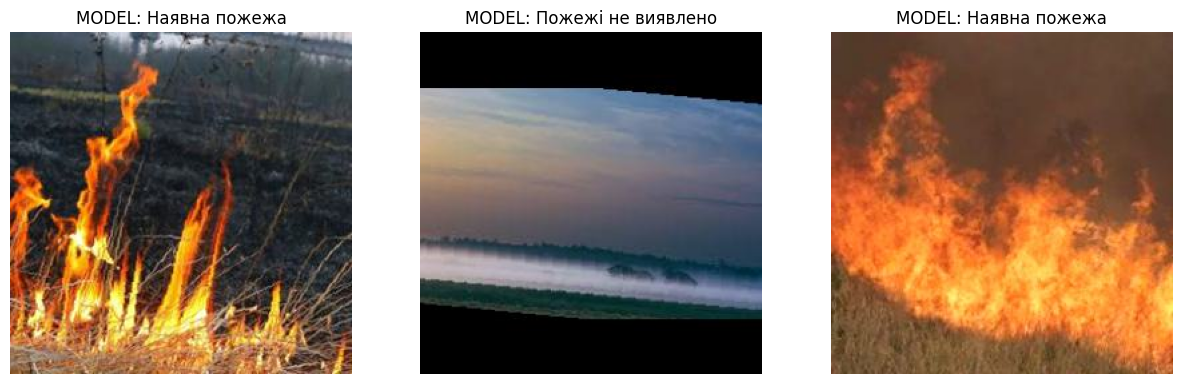

In [6]:
import random

def show_random_images_and_classes(dataset, model, num_images=3):
    # Вибір випадкових зображень
    random_indices = random.sample(range(len(dataset)), num_images)

    # Підготовка для передачі в модель
    images = [dataset[idx][0].unsqueeze(0).to(device) for idx in random_indices]

    # Отримання прогнозів (відповідей) моделі
    model.eval()
    with torch.no_grad():
        outputs = [model(image) for image in images]
        predicted_classes = [torch.argmax(output, 1).item() for output in outputs]

    # Визначення класів (0 - Пожежі не виявлено (clear), 1 - Наявна пожежа (fire))
    class_names = ['Пожежі не виявлено', 'Наявна пожежа']
    predicted_class_names = [class_names[predicted_class] for predicted_class in predicted_classes]

    # Відображення результатів
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i].squeeze().cpu().numpy()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(f'MODEL: {predicted_class_names[i]}')
        plt.axis('off')
    plt.show()

# Виклик функції для відображення трьох рандомних зображень та їх передбачень
show_random_images_and_classes(test_dataset, model, num_images=3)


## ГРАФІКИ НАВЧАННЯ МОДЕЛІ

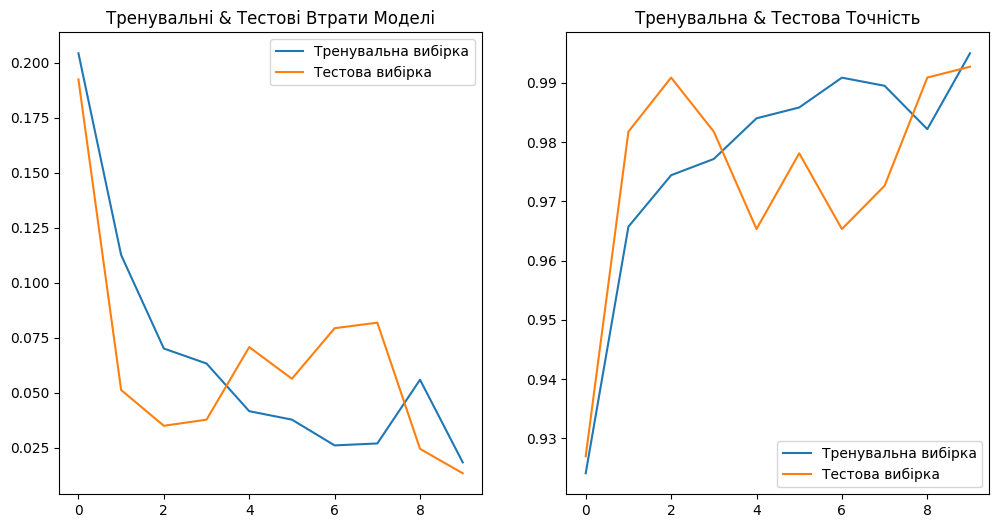

In [7]:
train_accuracy_np = [acc.cpu().detach().numpy() for acc in train_accuracy]
test_accuracy_np = [acc.cpu().detach().numpy() for acc in test_accuracy]

# Візуалізація
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Тренувальна вибірка')
plt.plot(test_loss, label='Тестова вибірка')
plt.title('Тренувальні & Тестові Втрати Моделі')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_np, label='Тренувальна вибірка')
plt.plot(test_accuracy_np, label = "Тестова вибірка")
plt.title('Тренувальна & Тестова Точність')
plt.legend()
plt.show()

## ТЕСТУВАННЯ МОДЕЛІ НА ВАШИХ ВЛАСНИХ ЗОБРАЖЕННЯХ

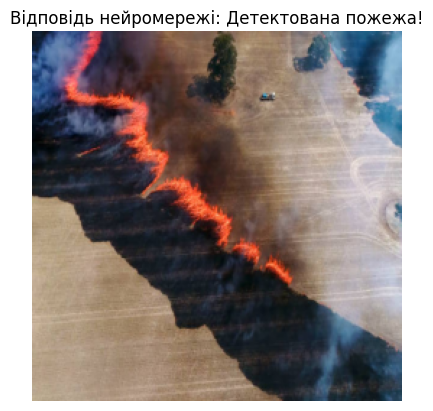

In [8]:
from PIL import Image

def classify_custom_image(image_path, model):
    #ФОРМАТ ВХІДНИХ ЗОБРАЖЕНЬ ДО МОДЕЛІ: 256X256, RGB
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Отримання прогнозу моделі 
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    # Визначення класу (0 - Пожежі не виявлено (clear), 1 - Детектована пожежа (fire))
    class_names = ['Пожежі не виявлено', 'Детектована пожежа!']
    predicted_class_name = class_names[predicted_class.item()]

    # Візуалізація
    plt.imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))
    plt.title(f'Відповідь нейромережі: {predicted_class_name}')
    plt.axis('off')
    plt.show()

# ТУТ ВКАЖІТЬ ШЛЯХ ДО ВАШОГО ЗОБРАЖЕННЯ 
custom_image_path = "/kaggle/input/fire-images/test_image_fire3.jpg"

# Виклик функції
classify_custom_image(custom_image_path, model)